### Initialise libraries and function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from scipy import interpolate
from scipy.interpolate import griddata
import time
import random

import MFI1D
import run_plumed as plumed

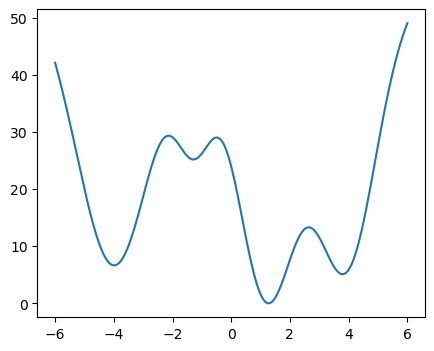

In [2]:
min_grid = -6
max_grid = 6
nbins = 401
grid = np.linspace(min_grid, max_grid, nbins)
y = - 45*np.exp(-0.5 * (((grid + 4.0) ** 2) / 1.5)) - 20*np.exp(-0.5 * (((grid + 1.26) ** 2) / 0.4)) - 50*np.exp(-0.5 * (((grid - 1.2) ** 2) / 1.0)) - 45*np.exp(-0.5 * (((grid - 3.9) ** 2) / 1.0)) + np.exp(-grid-5) + np.exp(grid-5)
y_string = "-45*exp(-0.5/1.5*(x+4.0)^2)-20*exp(-0.5/0.4*(x+1.26)^2)-50*exp(-0.5*(x-1.2)^2)-45*exp(-0.5*(x-3.9)^2)+exp(-x-5)^2+exp(x-5)"
y = y - min(y)

plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.show()

#Define constants 
bw = 0.05; bw2 = bw**2     
kT = 2.49 
n_steps = 100_000    
master = []    

### 1st simulation

In [3]:
master = []

#Run simuation
# plumed.run_langevin1D(n_steps, analytical_function = y_string, initial_position=-4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400)
# try: os.system("rm bck.*")
# except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS1")
position = MFI1D.load_position(position_name="position1")

#Run MFI algorithm to find force terms
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200)
grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results

#save results to master
master.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
        
#Patch master
[X, PD_patch, F_patch, FES, AD, AAD, OFE, AOFE] = MFI1D.patch_FES_AD_ofe(master, grid, y, nbins)

Ftot_ext = Ftot

/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dfds = np.where(pb_t < Ftot_den_limit, 0, Fpbt / pb_t) + Fbias - F_static
/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:323: RuntimeWarning: invalid value encountered in true_divide
  dfds = np.where(pb_t < Ftot_den_limit, 0, Fpbt / pb_t) + Fbias - F_static
/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:325: RuntimeWarning: invalid value encountered in true_divide
  Ftot = np.where(Ftot_den > Ftot_den_limit, Ftot_num / Ftot_den, 0)
/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:344: RuntimeWarning: invalid value encountered in true_divide
  ofv = np.where(Ftot_den > Ftot_den_limit, ofv_num / Ftot_den, 0) - np.square(Ftot)
/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:346: RuntimeWarning: divide by zero encountered in true_divide
  ofv *= np.where(temp_diff > 0, np.square(Ftot_den) / temp_diff, 0)
/home/uc

100.0 %   OFE = 12.5785


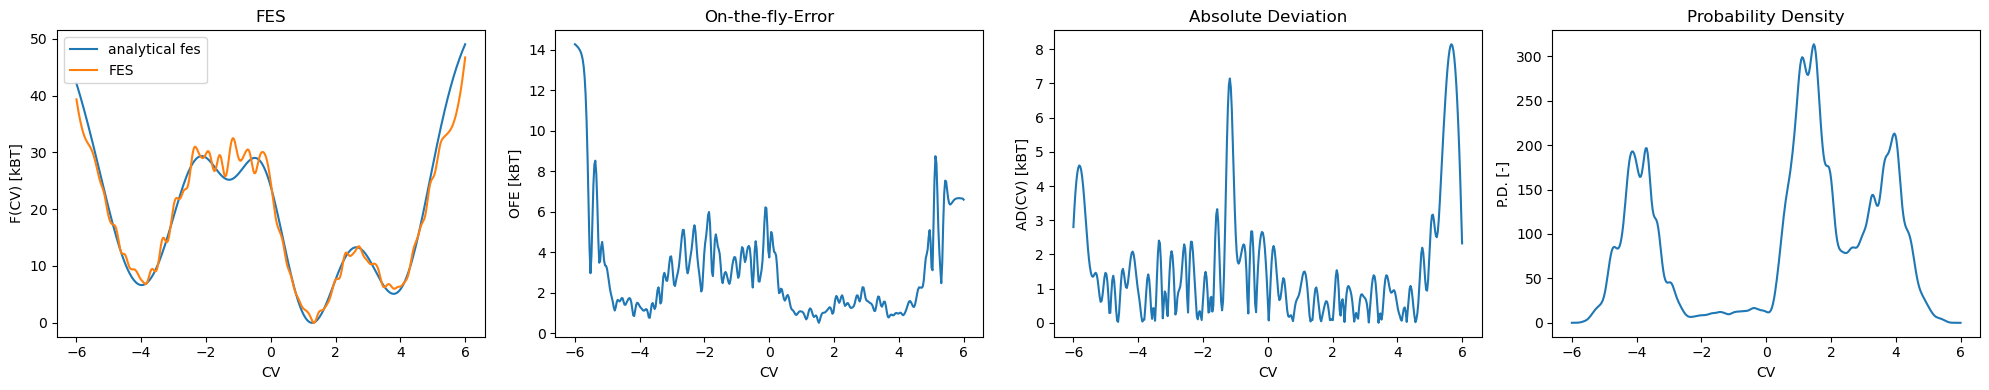

In [4]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

plt.subplot(1,4,2)
plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

plt.subplot(1,4,3)
plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

plt.subplot(1,4,4)
plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

plt.tight_layout(); plt.show()

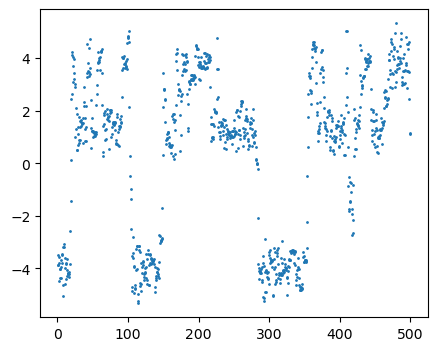

In [5]:
HILLS=MFI1D.load_HILLS(hills_name="HILLS1")
plt.figure(figsize=(5,4)); plt.scatter(HILLS[:,0], HILLS[:,1], s=1)

### Save FES as bias for next simulation

first column grid

second column energy 

third column force (derivative of enery)

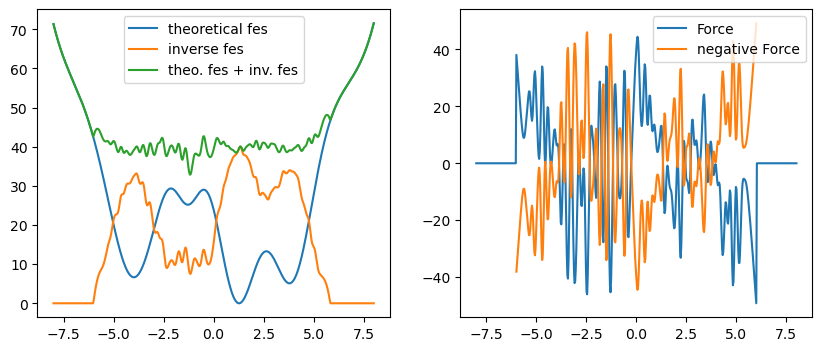

In [7]:
#Save transpose of [grid_p, FES_long, Ftot_long] defined on the same grid that plumed is using

# def make_external_bias_file(grid_old, FES, Ftot, grid_min_plumed, grid_max_plumed, nbins_plumed, FES_cutoff, file_name_extension=""):
    
#     #define plumed grid (so that plumed can explore values outside of shorter grid defined above)
#     grid_plumed = np.linspace(grid_min_plumed, grid_max_plumed, nbins_plumed)
    
#     #Interpolate FES onto plumed grid
#     FES_plumed = np.interp(grid_plumed, grid_old, FES)
#     FES_plumed = np.where(FES_plumed > FES_cutoff, FES_cutoff, FES_plumed)
#     FES_plumed = -FES_plumed + FES_cutoff   
    
#     #Interpolate Force on long grid
#     Ftot_plumed = np.interp(grid_plumed, grid_old, -Ftot)

#     #Do transpose 
#     external_bias_vector = np.array([grid_plumed, FES_plumed, Ftot_plumed]).T
    
#     with open("external_biFES_plumedas.dat" + file_name_extension, "w") as f:
#         #Write some information for plumed
#         f.write("#! FIELDS p.x external.bias der_p.x\n")
#         f.write("#! SET min_p.x {}\n".format(grid_min_plumed))
#         f.write("#! SET max_p.x {}\n".format(grid_max_plumed))
#         f.write("#! SET nbins_p.x {}\n".format(nbins_plumed-1))
#         f.write("#! SET periodic_p.x false\n")
    
#         #Save array to external_bias.dat file 
#         np.savetxt("external_bias.dat" + file_name_extension , external_bias_vector, fmt="%.8f", delimiter="   ")
        

def make_external_bias(grid_old, FES, Ftot, grid_min_plumed, grid_max_plumed, FES_cutoff, file_name_extension=""):
    
    #create extended grid so that it goes to reaches grid_min_plumed and grid_max_plumed
    grid_spacing = grid_old[1] - grid_old[0]
    lower_new_values = int((grid_old[0] - grid_min_plumed)/grid_spacing) + 1
    upper_new_values = int((grid_max_plumed - grid_old[-1])/grid_spacing) + 1
    new_end_values = (grid_old[0] - grid_spacing*lower_new_values, grid_old[-1] + grid_spacing*upper_new_values) 
       
    grid_plumed = np.pad(grid_old, (lower_new_values, upper_new_values), mode="linear_ramp", end_values=new_end_values)
    nbins_plumed = len(grid_plumed)
    
    #Extend FES and Ftot using constant values
    FES_plumed = np.where(FES > FES_cutoff, FES_cutoff, FES)
    FES_plumed = np.pad(FES_plumed, (lower_new_values, upper_new_values), mode="constant", constant_values=FES_cutoff)
    FES_plumed = -FES_plumed + FES_cutoff   
    Ftot_plumed = np.pad(-Ftot, (lower_new_values, upper_new_values), mode="constant")
    
    #Save to external_bias.dat file
    head_text = "#! FIELDS p.x external.bias der_p.x\n#! SET min_p.x " + str(grid_min_plumed) + "\n#! SET max_p.x " + str(grid_max_plumed) + "\n#! SET nbins_p.x " + str(nbins_plumed-1) + "\n#! SET periodic_p.x false"
    external_bias_vector = np.array([grid_plumed, FES_plumed, Ftot_plumed]).T       
    np.savetxt("external_bias.dat" + file_name_extension , external_bias_vector, fmt="%.8f", delimiter="   ", header=head_text, comments="")

    return [grid_plumed, FES_plumed, Ftot_plumed]
    
    
    
# make_external_bias_file(grid_old=grid, FES=FES, Ftot=Ftot, grid_min_plumed=-8, grid_max_plumed=8, nbins_plumed=501, FES_cutoff=40)    

[grid_plumed, FES_plumed, Ftot_plumed] = make_external_bias(grid, FES, Ftot, grid_min_plumed=-8, grid_max_plumed=8, FES_cutoff=40)

#plot results
y_plumed = - 45*np.exp(-0.5 * (((grid_plumed + 4.0) ** 2) / 1.5)) - 20*np.exp(-0.5 * (((grid_plumed + 1.26) ** 2) / 0.4)) - 50*np.exp(-0.5 * (((grid_plumed - 1.2) ** 2) / 1.0)) - 45*np.exp(-0.5 * (((grid_plumed - 3.9) ** 2) / 1.0)) + np.exp(-grid_plumed-5) + np.exp(grid_plumed-5)
y_plumed = y_plumed - min(y_plumed)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(grid_plumed, y_plumed, label="theoretical fes")
plt.plot(grid_plumed, FES_plumed, label="inverse fes")
plt.plot(grid_plumed, FES_plumed + y_plumed, label="theo. fes + inv. fes")
plt.legend()

plt.subplot(1,2,2)
plt.plot(grid_plumed, Ftot_plumed, label="Force")
plt.plot(grid, Ftot, label="negative Force")
plt.legend(); plt.show()

### Run 2nd simulation with external bias

In [10]:
def run_langevin1D_external(simulation_steps,
                   analytical_function = "7*x^4-23*x^2", periodic= "NO",
                   initial_position=0.0, temperature=1, time_step=0.005,
                   grid_min=-3.0, grid_max=3.0, grid_bin=200,
                   gaus_width=0.1, gaus_height=1, biasfactor=10, gaus_pace=100, position_pace=0,
                   hp_centre=0.0, hp_kappa=0,
                   lw_centre=0.0, lw_kappa=0,
                   uw_centre=0.0, uw_kappa=0,
                   external_bias_file=""):
    """Function to run a langevin simulation in 1 dimension. Default analytical potential: y = 7*x^4-23*x^2.

    Args:
        simulation_steps (int): Number of steps in simulation
        analytical_function (str, optional): The analytical function to be analysed. Defaults to "7*x^4-23*x^2".
        periodic_boundaries (str, optional): Information wheather boundary conditions are periodic ("ON") or not ("NO"). Defaults to "NO".
        initial_position (float, optional): Initial position of simulation. Defaults to 0.0.
        temperature (int, optional): Temperature of simulation (units in kT). Defaults to 1.
        time_step (float, optional): Length of one time step (units in ps). Defaults to 0.005.
        grid_min (float, optional): Minimum value of grid where the bias is stored. Defaults to -3.0.
        grid_max (float, optional): Maximum value of grid where the bias is stored. Defaults to 3.0.
        grid_bin (int, optional): Number of distinct bins in grid. Defaults to 200.
        gaus_width (float, optional): Gaussian width (sigma) of metadynamics bias. Defaults to 0.1.
        gaus_height (int, optional): Gaussian height of metadynamics bias. Defaults to 1.
        biasfactor (int, optional): Biasfactor of metadynamics bias. Defaults to 10.
        gaus_pace (in t, optional): Pace of deposition of metadynamics hills. Defaults to 100.
        position_pace (int, optional): Pace of recording the CV in the position file. When position_pace=0, position_pace = gaus_pace/10. Defaults to 0.
        hp_centre (float, optional): position of harmonic potential. Defaults to 0.0.
        hp_kappa (int, optional): force_constant of harmonic potential. Defaults to 0.
        lw_centre (float, optional): position of lower wall potential. Defaults to 0.0.
        lw_kappa (int, optional): force_constant of lower wall potential. Defaults to 0.
        uw_centre (float, optional): position of upper wall potential. Defaults to 0.0.
        uw_kappa (int, optional): force_constant of upper wall potential. Defaults to 0.
    """


    if periodic == "YES":
        periodic_boundaries = str(grid_min) + "," + str(grid_max)
    elif periodic == "NO":
        periodic_boundaries = "NO"
    else:
        print("Please specify if you want to use periodic boundaries using \"YES\" or \"NO\". \nFor now, no periodic boundaries are assumed")
        periodic_boundaries = "NO"
        grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results

        
    with open("input" ,"w") as f:
        print("""temperature {}
tstep {}
friction 1
dimension 1
nstep {}
ipos {}""".format(temperature, time_step, simulation_steps,  initial_position) ,file=f)

        if periodic_boundaries == "NO":
            f.write("periodic false")
        else:
            f.write("periodic on ")
            f.write("min {} ".format(grid_min))
            f.write("max {}".format(grid_max))


    with open("plumed.dat" ,"w") as f:
        print("""p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ARG=p.x FUNC=({}) PERIODIC={}
bb: BIASVALUE ARG=ff""".format(analytical_function, periodic_boundaries) ,file=f)

    with open("plumed.dat" ,"a") as f:
        # Metadynamics bias. To activate, the height of the bias needs to be a positive number.
        if gaus_height > 0:
            f.write("METAD ARG=p.x SIGMA={} HEIGHT={} BIASFACTOR={} GRID_MIN={} GRID_MAX={} GRID_BIN={} PACE={} \
TEMP={} \n".format(gaus_width, gaus_height, biasfactor, grid_min, grid_max, grid_bin, gaus_pace, temperature * 120))

        # Harmonic potential bias. To activate, the force constant (kappa) needs to be a positive number
        if hp_kappa > 0:
            f.write("RESTRAINT ARG=p.x AT={} KAPPA={} LABEL=restraint \n".format(hp_centre, hp_kappa))

        # Lower wall bias. To activate, the force constant (kappa) needs to be a positive number
        if lw_kappa > 0:
            f.write("LOWER_WALLS ARG=p.x AT={} KAPPA={} LABEL=lowerwall \n".format(lw_centre, lw_kappa))

        # Upper wall bias. To activate, the force constant (kappa) needs to be a positive number
        if uw_kappa > 0:
            f.write("UPPER_WALLS ARG=p.x AT={} KAPPA={} LABEL=upperwall \n".format(uw_centre, uw_kappa))
            
        if external_bias_file != "":
            f.write("EXTERNAL ARG=p.x FILE={} LABEL=external \n".format(external_bias_file))

        # Print position of system. If position_pace = 0, it will be position_pace = gaus_pace/10
        if position_pace == 0: position_pace = int(gaus_pace / 10)
        f.write("PRINT FILE=position ARG=p.x STRIDE={}".format(position_pace))


    os.system("plumed pesmd < input >/dev/null 2>&1")

In [15]:
#Run metaD simulation with external bias
run_langevin1D_external(n_steps, analytical_function = y_string, initial_position=4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400, external_bias_file="external_bias.dat")
try: os.system("rm bck.*")
except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")
position = MFI1D.load_position(position_name="position")

#Run MFI algorithm
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200, F_static=-Ftot_ext)


grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results


#save results to master
master.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
        
#Patch master
[X, PD_patch, F_patch, FES, AD, AAD, OFE, AOFE] = MFI1D.patch_FES_AD_ofe(master, grid, y, nbins)

100.0 %   OFE = 14.0301


rm: cannot remove 'bck.*': No such file or directory


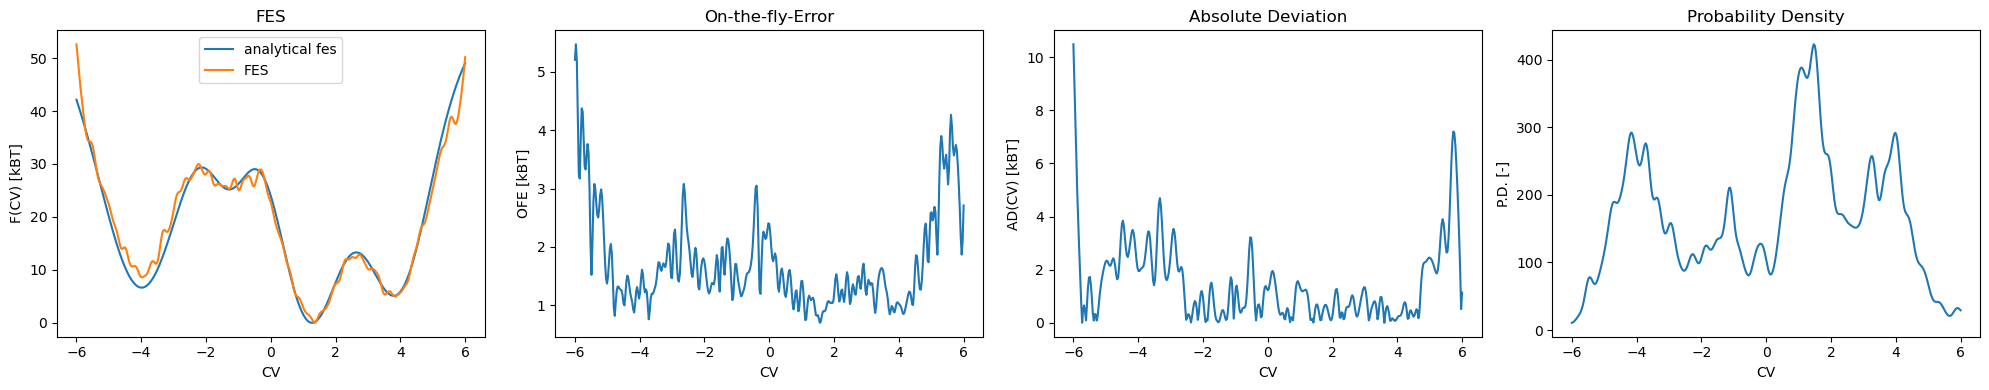

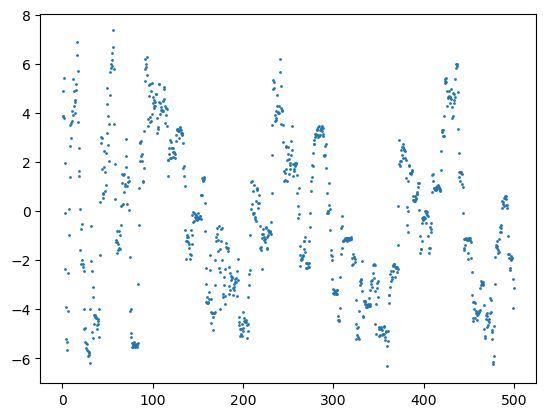

In [16]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

plt.subplot(1,4,2)
plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

plt.subplot(1,4,3)
plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

plt.subplot(1,4,4)
plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

plt.tight_layout(); plt.show()

HILLS=MFI1D.load_HILLS(hills_name="HILLS")
plt.scatter(HILLS[:,0], HILLS[:,1], s=1); plt.show();


In [14]:
print(np.shape(master))

(1, 4, 401)


### Comparison with just one long simulation

100.0 %   OFE = 12.4579


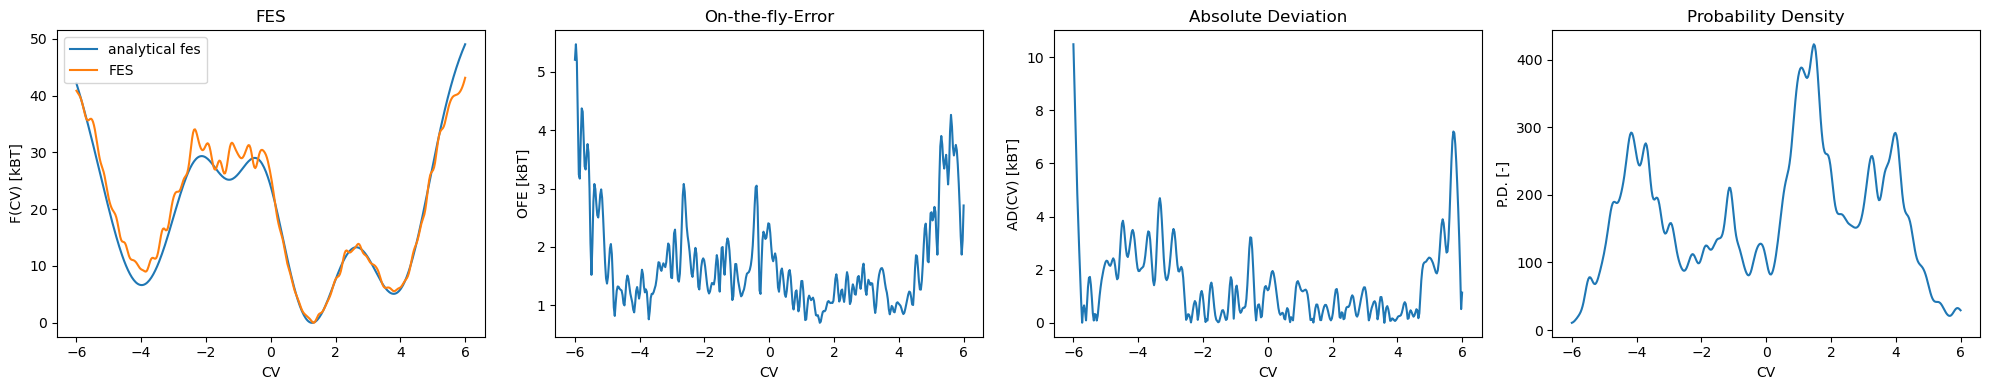

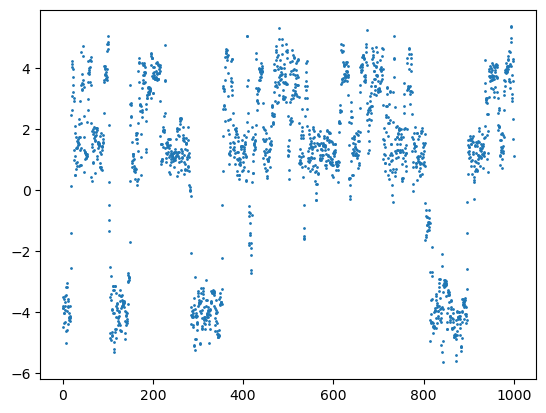

In [20]:
# #Run simuation
# plumed.run_langevin1D(int(n_steps*2), analytical_function = y_string, initial_position=-4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400)
# try: os.system("rm bck.*")
# except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS2")
position = MFI1D.load_position(position_name="position2")

#Run MFI algorithm to find force terms
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200)
grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results


for _ in [1]:
    plt.figure(figsize=(20,4))
    plt.subplot(1,4,1)
    plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

    plt.subplot(1,4,2)
    plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

    plt.subplot(1,4,3)
    plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

    plt.subplot(1,4,4)
    plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

    plt.tight_layout(); plt.show()

    HILLS=MFI1D.load_HILLS(hills_name="HILLS2")
    plt.scatter(HILLS[:,0], HILLS[:,1], s=1); plt.show();